In [39]:
import jax.numpy as jnp
import jax
from jax.scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
from functools import partial
from tqdm.auto import tqdm

seed = 0
key = jax.random.key(seed)

In [40]:
height = 128
width = 128
angle = 1.
num_gaussians = 2

canvas = jnp.zeros((height, width, 3), dtype=jnp.float32)
means = jnp.array([[64, 80], [64, 20]], dtype=jnp.float32)
sigma1 = jnp.array([20, 20], dtype=jnp.float32)
sigma2 = jnp.array([20, 20], dtype=jnp.float32)
covariance = jnp.stack([jnp.diag(sigma1**2), jnp.diag(sigma1**2)])
colors = jnp.clip(jax.random.normal(key, (2, 3)), 0, 1)
r = R.from_euler('x', [angle,])
rotmat = r.as_matrix()[1:, 1:]

In [45]:
@partial(jax.jit, static_argnames=['height', 'width'])
def rasterize_single_gaussian(xy, gaussian, height=128, width=128):
    mean, covariance, color = gaussian
    pdf = jax.scipy.stats.multivariate_normal.pdf(xy, mean, covariance)
    intensity = rearrange(pdf, '(h w) -> h w', h=height, w=width) / pdf.max()
    rasterized_color = jnp.repeat(intensity[..., None], 3, axis=2) * color[None, ...]
    return rasterized_color

def rasterize(means: jnp.array, covariances: jnp.array, colors: jnp.array, height: int, width: int) -> jnp.array:
    assert means.shape[0] == covariances.shape[0] == colors.shape[0]
    canvas = jnp.zeros((height, width, 3))
    x, y = jnp.mgrid[0:canvas.shape[0], 0:canvas.shape[1]]
    xy = jnp.column_stack([x.flatten(), y.flatten()])
    num_gaussians = means.shape[0]
    for i in range(num_gaussians):
        gaussian = [means[i], covariances[i], colors[i]]
        rasterized_color = rasterize_single_gaussian(xy, gaussian, height, width)
        canvas += rasterized_color
    return canvas

def outside_interval_loss(array, min, max):
    return (array[array < min] ** 2).mean() + (array[array > max] ** 2).mean()

def pixel_loss(means, covariance, colors, height, width):
    renderred_gaussians = rasterize(means, covariance, colors, height, width)
    loss = (renderred_gaussians[:, :64] - jnp.array([0, 0, 1])).mean() ** 2 + (renderred_gaussians[:, 64:] - jnp.array([1, 0, 0])).mean() ** 2 + jnp.clip(colors, -jnp.inf, 0).mean() ** 2
    return loss

In [53]:
colors[colors > 1.]

Array([1.2649856, 1.0771415, 1.7265592, 1.5029573], dtype=float32)

In [46]:
lr = 1
grad_fn = jax.value_and_grad(pixel_loss, argnums=[0, 1, 2])
for step in range(100):
    loss, gradients = grad_fn(means, covariance, colors, height, width)
    means = means - gradients[0] * lr
    covariance = covariance - gradients[1] * lr
    colors = colors - gradients[2] * lr
    if step % 10 == 0:
        print(loss)


0.17206548
0.051027834
0.017012266
0.0056986995
0.0019234361
0.00065689126
0.00022837227
8.146836e-05
3.011512e-05
1.1648059e-05


In [49]:
colors

Array([[1.2649856 , 1.0771415 , 1.7265592 ],
       [1.5029573 , 0.8151332 , 0.59597176]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


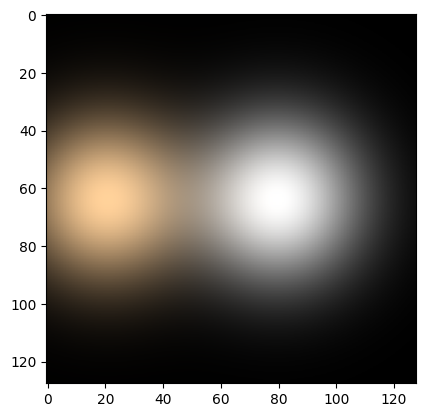

In [48]:
renderred_gaussians = rasterize(means, covariance, jnp.clip(colors, 0, 1), height, width)
plt.imshow(renderred_gaussians)